# Statistical Analysis of Brazilian Air Force Aircraft Occurrences

## Project Description

This project's main objective is to carry out a comprehensive statistical analysis of occurrence data involving Brazilian Air Force (FAB) aircraft. The purpose is to answer crucial questions about the profile of aircraft involved in accidents and investigate possible correlations between aircraft age, area factor, type of occurrence.

## Data Description

The aeronautical occurrences database is maintained by the Aeronautical Accident Investigation and Prevention Center (CENIPA). This database covers the period from 2010 to 2021 and comprises the record of aeronautical occurrences reported to CENIPA that occurred in Brazilian territory.

## Methodology

This work will be based on the “Six-step Statistical Investigation Method”.

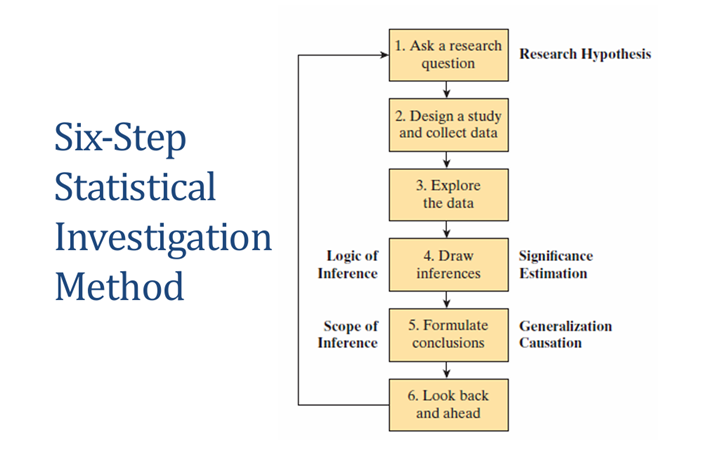

### 1. Research Question

Is the age of an aircraft related to occurrences?

### 2. Study and Data

For the search, we collected data from FAB. More specifically, we worked with four different csv files containing data from "ocorrencias" (occurrences), "tipo de ocorrencia" (type of occurrence), "aeronave" (aircraft) and "fator" (factor).

In [ ]:
!pip install pywaffle -q
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go, express as px
from pywaffle import Waffle
import numpy as np
import seaborn as sns
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from scipy.stats import chi2
from scipy.stats import chi2_contingency

In [ ]:
# to draw normal distributions

def plot_normal_distribution(z_score, alpha):
    # Set the mean and standard deviation for the normal distribution
    mu = 0  # Mean
    sigma = 1  # Standard Deviation

    left_tail = -stats.norm.ppf(1 - alpha / 2)
    right_tail = stats.norm.ppf(1 - alpha / 2)

    # Determine the x-axis limits based on the provided Z-score and tails
    x_limit_left = min(-z_score - 2, -left_tail - 2)
    x_limit_right = max(z_score + 2, right_tail + 2)

    # Generate data points for the normal distribution within the updated limits
    x = np.linspace(x_limit_left, x_limit_right, 10000)
    y = stats.norm.pdf(x, mu, sigma)

    # Create a figure and axis for the plot
    fig, ax = plt.subplots()

    # Plot the normal distribution
    ax.plot(x, y, label='Normal Distribution')

    # Plot only the blue line (provided Z-score)
    ax.axvline(z_score, color='black', linestyle='--', label=f'Provided Z-Score (Z = {z_score:.2f})')

    ax.fill_between(x, 0, y, color='grey', alpha=0.25, label=f'Non-rejection region')
    ax.fill_between(x, 0, y, where=(x < left_tail), color='red')
    ax.fill_between(x, 0, y, where=(x > right_tail), color='red', label=f'Rejection region for alpha = {alpha}')

    # Set labels and legend
    ax.set_xlabel('Z-Score')
    ax.set_ylabel('Probability Density')
    ax.set_title('Normal Distribution')
    ax.legend(loc="upper left")

    # Show the plot
    plt.show()

In [ ]:
def plot_f_test_distribution(f_score, dfn, dfd, alpha=0.05):
    # Calculate the critical F-value for the given alpha
    critical_f_value = stats.f.ppf(1 - alpha, dfn, dfd)

    # Generate data points for the F-distribution
    x = np.linspace(0, max(2 * critical_f_value, f_score + 1), 1000)
    y = stats.f.pdf(x, dfn, dfd)

    # Create a figure and axis for the plot
    fig, ax = plt.subplots()

    # Plot the F-distribution
    ax.plot(x, y, label='F-Distribution')

    # Shade the rejection region in red
    x_rejection = np.linspace(critical_f_value, max(2 * critical_f_value, f_score + 1), 100)
    y_rejection = stats.f.pdf(x_rejection, dfn, dfd)
    ax.fill_between(x_rejection, 0, y_rejection, color='red', alpha=0.5, label=f'Rejection Region (α = {alpha})')

    # Mark the critical F-value on the plot
    ax.axvline(f_score, color='black', linestyle='--', label=f'F-score ({f_score:.2f})')

    # Set labels and legend
    ax.set_xlabel('F-Value')
    ax.set_ylabel('Probability Density')
    ax.set_title(f'F-Test Distribution with Rejection Region (α = {alpha})')
    ax.legend()

    # Show the plot
    plt.show()


In [ ]:
df_ocorrencias = pd.read_csv('https://raw.githubusercontent.com/igor-diniz/MECD-Statistics/main/data/ocorrencia.csv', sep=';', error_bad_lines=False,  encoding='latin-1')
df_tipo_ocorrencia = pd.read_csv('https://raw.githubusercontent.com/igor-diniz/MECD-Statistics/main/data/ocorrencia_tipo.csv', sep=';', error_bad_lines=False,  encoding='latin-1')
df_aeronave = pd.read_csv('https://raw.githubusercontent.com/igor-diniz/MECD-Statistics/main/data/aeronave.csv', sep=';', error_bad_lines=False,  encoding='latin-1')
df_fator = pd.read_csv('https://raw.githubusercontent.com/igor-diniz/MECD-Statistics/main/data/fator_contribuinte.csv', sep=';', error_bad_lines=False,  encoding='latin-1')


In [ ]:
df_ocorrencias.set_index('codigo_ocorrencia', inplace=True)
df_tipo_ocorrencia.set_index('codigo_ocorrencia1', inplace=True)
df_aeronave.set_index('codigo_ocorrencia2', inplace=True)
df_fator.set_index('codigo_ocorrencia3', inplace=True)

In [ ]:
df_ocorrencias.drop(['codigo_ocorrencia1','codigo_ocorrencia2','codigo_ocorrencia3','codigo_ocorrencia4'], inplace=True, axis=1)

In [ ]:
df = df_ocorrencias.join(df_aeronave).join(df_fator).join(df_tipo_ocorrencia)
df

,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,...,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total,fator_nome,fator_aspecto,fator_condicionante,fator_area,ocorrencia_tipo,ocorrencia_tipo_categoria,taxonomia_tipo_icao
28256,ACIDENTE,-22.2180555556,-47.1763888889,MOGI GUAÇU,SP,BRASIL,***,07/01/2007,11:30:00,***,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPERAÇÃO A BAIXA ALTITUDE,OPERAÇÃO A BAIXA ALTITUDE,LALT
28335,ACIDENTE,-23.3444444444,-51.0633333333,LONDRINA,PR,BRASIL,***,19/01/2007,12:30:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VOO CONTROLADO CONTRA O TERRENO,VOO CONTROLADO CONTRA O TERRENO,CFIT
28355,ACIDENTE,-17.2541666667,-43.8536111111,BOCAIÚVA,MG,BRASIL,***,18/01/2007,09:10:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FALHA ESTRUTURAL,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP
28375,ACIDENTE,-23.6122222222,-51.385,APUCARANA,PR,BRASIL,***,26/01/2007,18:15:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COLISÃO COM OBSTÁCULO DURANTE A DECOLAGEM E POUSO,COLISÃO COM OBSTÁCULO DURANTE A DECOLAGEM E POUSO,CTOL
28377,ACIDENTE,***,***,IMPERATRIZ,MA,BRASIL,***,27/01/2007,11:18:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FALHA DO MOTOR EM VOO,FALHA OU MAU FUNCIONAMENTO DO MOTOR | FALHA DO...,SCF-PP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82037,INCIDENTE,-12.90861111111,-38.3225,SALVADOR,BA,BRASIL,SBSV,18/04/2023,11:25:00,SIM,...,REGULAR,NENHUM,0.0,NaN,NaN,NaN,NaN,COLISÃO COM AVE,COLISÃO COM AVE,BIRD
82038,INCIDENTE,-23.43555555555,-46.47305555555,GUARULHOS,SP,BRASIL,SBGR,18/04/2023,09:55:00,SIM,...,REGULAR,NENHUM,0.0,NaN,NaN,NaN,NaN,COLISÃO COM AVE,COLISÃO COM AVE,BIRD
82039,INCIDENTE,-22.81,-43.25055555555,RIO DE JANEIRO,RJ,BRASIL,SBGL,17/04/2023,13:20:00,SIM,...,REGULAR,NENHUM,0.0,NaN,NaN,NaN,NaN,COLISÃO COM AVE,COLISÃO COM AVE,BIRD
82045,INCIDENTE,-25.53166666666,-49.17611111111,SÃO JOSÉ DOS PINHAIS,PR,BRASIL,SBCT,09/04/2023,20:50:00,SIM,...,REGULAR,NENHUM,0.0,NaN,NaN,NaN,NaN,COLISÃO COM AVE,COLISÃO COM AVE,BIRD


In [ ]:
df['ocorrencia_ano'] = df['ocorrencia_dia'].apply(lambda x: int(x[-4:]))
df["idade_aeronave"] = df["ocorrencia_ano"] - df["aeronave_ano_fabricacao"]

**Variables to be used**

The variables that will be used for the analysis are:

*   aeronave_ano_fabricacao
*   aeronave_nivel_dano
*   aeronave_fatalidades_total
*   fator_aspecto
*   ocorrencia_classificacao
*   ocorrencia_dia
*   ocorrencia_hora









In [ ]:
dados = df[["aeronave_ano_fabricacao", "aeronave_nivel_dano", "aeronave_fatalidades_total", "fator_area", "ocorrencia_classificacao", "ocorrencia_dia", "idade_aeronave", "ocorrencia_longitude", "ocorrencia_latitude", "ocorrencia_hora"]].copy()


**Cleaning Criteria**

Since we have a broad number of occurrences collected (13411), and we are going to work taking samples to implement statistical inferences, there is no problem to simply drop rows with missing values as we continue with a vast number of occurrences.  

Therefore, we will drop the rows with missing values to clean our dataset.

In [ ]:
dados.dropna(inplace=True)
dados = dados[dados['aeronave_ano_fabricacao'] > 0]
dados = dados[dados['aeronave_nivel_dano'] != "***"]


**Collecting INMET Data**

We also extended our dataset with data from the National Institute of Meteorology (INMET) to retrieve weather data during the occurrences, so that we could analyze how the wind may impact aircraft incidents.






In [ ]:
dados['timestamp'] = pd.to_datetime(dados['ocorrencia_dia'] + ' ' + dados['ocorrencia_hora']).dt.floor('H')

In [ ]:
dados[["ocorrencia_longitude", "ocorrencia_latitude", "ocorrencia_dia", "ocorrencia_hora" , "timestamp"]]

,ocorrencia_longitude,ocorrencia_latitude,ocorrencia_dia,ocorrencia_hora,timestamp
45331,-46.4730555556,-23.4355555556,06/01/2012,13:44:00,2012-06-01 13:00:00
45331,-46.4730555556,-23.4355555556,06/01/2012,13:44:00,2012-06-01 13:00:00
45331,-46.4730555556,-23.4355555556,06/01/2012,13:44:00,2012-06-01 13:00:00
45331,-46.4730555556,-23.4355555556,06/01/2012,13:44:00,2012-06-01 13:00:00
45331,-46.4730555556,-23.4355555556,06/01/2012,13:44:00,2012-06-01 13:00:00
...,...,...,...,...,...
81169,-47.96638888888,-16.26194444444,07/12/2022,14:50:00,2022-07-12 14:00:00
81169,-47.96638888888,-16.26194444444,07/12/2022,14:50:00,2022-07-12 14:00:00
81169,-47.96638888888,-16.26194444444,07/12/2022,14:50:00,2022-07-12 14:00:00
81169,-47.96638888888,-16.26194444444,07/12/2022,14:50:00,2022-07-12 14:00:00


In [ ]:
import requests

def get_weather_data(latitude, longitude, timestamp):

    base_url = "https://archive-api.open-meteo.com/v1/archive"
    hourly = "temperature_2m,rain,weathercode,windspeed_100m"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": timestamp.strftime("%Y-%m-%d"),
        "end_date": timestamp.strftime("%Y-%m-%d"),
        "hourly": hourly
    }

    response = requests.get(base_url, params=params)
    weather_data = response.json()
    weather = pd.DataFrame(weather_data['hourly'])
    weather["timestamp"] = pd.to_datetime(weather["time"])
    # You can set 'time' as the index if needed:
    weather.set_index('timestamp', inplace=True)
    # Now you have a DataFrame with the provided data
    if response.status_code == 200:
        return weather.loc[timestamp]
    else:
        # Handle errors here, e.g., raise an exception or return an error message
        return f"Error: {response.status_code}"

In [ ]:
year = "2022"
filtered_df = dados[dados['ocorrencia_dia'].apply(lambda x: x[-4:]) == year]
filtered_df = dados[dados["ocorrencia_latitude"] != "***"]
filtered_df = filtered_df[filtered_df["ocorrencia_longitude"] != "***"]

Getting weather data for every accident in DataFrame

In [ ]:
#df_weather = pd.DataFrame()
#i = 1
#for row in filtered_df.iterrows():
#  # new_row = dict(row)
#  print(len(df_weather))
#  try:
#    weather_data = get_weather_data(row[1]["ocorrencia_latitude"], row[1]["ocorrencia_longitude"], row[1]["timestamp"])
#  except:
#    continue
#  row[1]["rain"] = weather_data["rain"]
#  row[1]["windspeed_100m"] = weather_data["windspeed_100m"]
#  df_weather = df_weather.append(row[1])


In [ ]:
#df_weather.to_csv("weather.csv")

In [ ]:
df_weather = pd.read_csv("weather.csv", index_col=0)
df_weather

,aeronave_ano_fabricacao,aeronave_nivel_dano,aeronave_fatalidades_total,fator_area,ocorrencia_classificacao,ocorrencia_dia,idade_aeronave,ocorrencia_longitude,ocorrencia_latitude,ocorrencia_hora,timestamp,rain,windspeed_100m
45331,2001.0,NENHUM,0.0,FATOR OPERACIONAL,ACIDENTE,06/01/2012,11.0,-46.473056,-23.435556,13:44:00,2012-06-01 13:00:00,0.0,11.4
45331,2001.0,NENHUM,0.0,FATOR HUMANO,ACIDENTE,06/01/2012,11.0,-46.473056,-23.435556,13:44:00,2012-06-01 13:00:00,0.0,11.4
45331,2001.0,NENHUM,0.0,FATOR HUMANO,ACIDENTE,06/01/2012,11.0,-46.473056,-23.435556,13:44:00,2012-06-01 13:00:00,0.0,11.4
45331,2001.0,NENHUM,0.0,FATOR HUMANO,ACIDENTE,06/01/2012,11.0,-46.473056,-23.435556,13:44:00,2012-06-01 13:00:00,0.0,11.4
45331,2001.0,NENHUM,0.0,FATOR HUMANO,ACIDENTE,06/01/2012,11.0,-46.473056,-23.435556,13:44:00,2012-06-01 13:00:00,0.0,11.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81169,1994.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,07/12/2022,28.0,-47.966389,-16.261944,14:50:00,2022-07-12 14:00:00,0.0,3.9
81169,1994.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,07/12/2022,28.0,-47.966389,-16.261944,14:50:00,2022-07-12 14:00:00,0.0,3.9
81169,1994.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,07/12/2022,28.0,-47.966389,-16.261944,14:50:00,2022-07-12 14:00:00,0.0,3.9
81169,1994.0,SUBSTANCIAL,0.0,FATOR HUMANO,ACIDENTE,07/12/2022,28.0,-47.966389,-16.261944,14:50:00,2022-07-12 14:00:00,0.0,3.9


### 3. Exploratory data analysis (EDA)

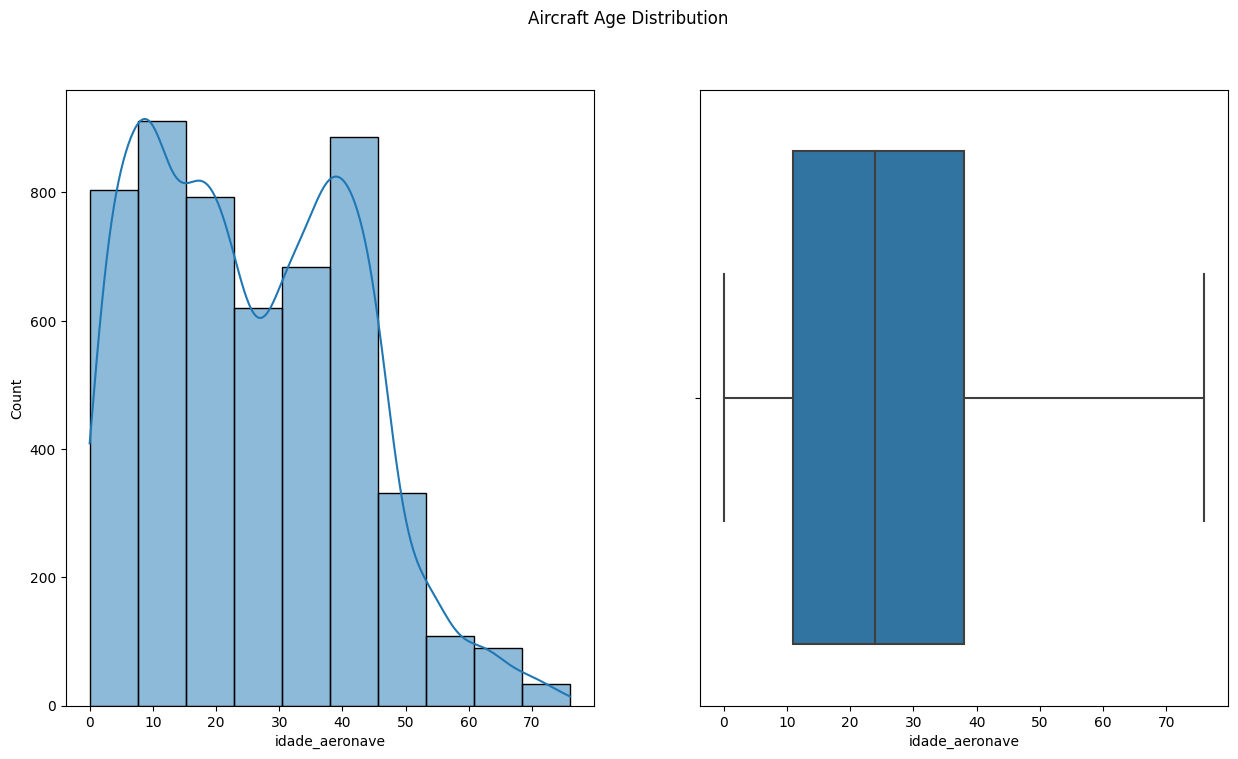

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 8))
sns.histplot(data=dados, x="idade_aeronave", kde=True, bins=10, ax=axs[0])
sns.boxplot(data=dados, x="idade_aeronave", ax=axs[1])
fig.suptitle("Aircraft Age Distribution")
plt.show()

In [ ]:
dados.describe()

,aeronave_ano_fabricacao,aeronave_fatalidades_total,idade_aeronave
count,5258.000000,5258.000000,5258.000000
mean,1990.858692,0.629897,25.534994
std,16.222558,1.454515,16.230823
min,1945.000000,0.000000,0.000000
25%,1977.000000,0.000000,11.000000
50%,1992.000000,0.000000,24.000000
75%,2006.000000,0.000000,38.000000
max,2021.000000,10.000000,76.000000


#### Explaining what is considered new and old aircrafts​

* We discretized aircraft ages into quartiles to distinguish between new and old airplanes.

* After obtaining [11, 24, 38] for the [25%, 50%, 75%] quantiles respectively, we decided that new airplanes are those with an age less than or equal to 11, which corresponds to the first quartile (25%). Conversely, old aircraft are those with an age greater than 11.

* We chose to use quartiles because it allows for a roughly equal distribution of occurrences in each discretized interval, as illustrated in the chart on the following slide.

In [ ]:
q1= dados[dados["idade_aeronave"] <= 11]
q2= dados[dados["idade_aeronave"].between(12, 24)]
q3= dados[dados["idade_aeronave"].between(25,38)]
q4= dados[dados["idade_aeronave"] > 38]
q234 = dados[dados["idade_aeronave"] > 11]

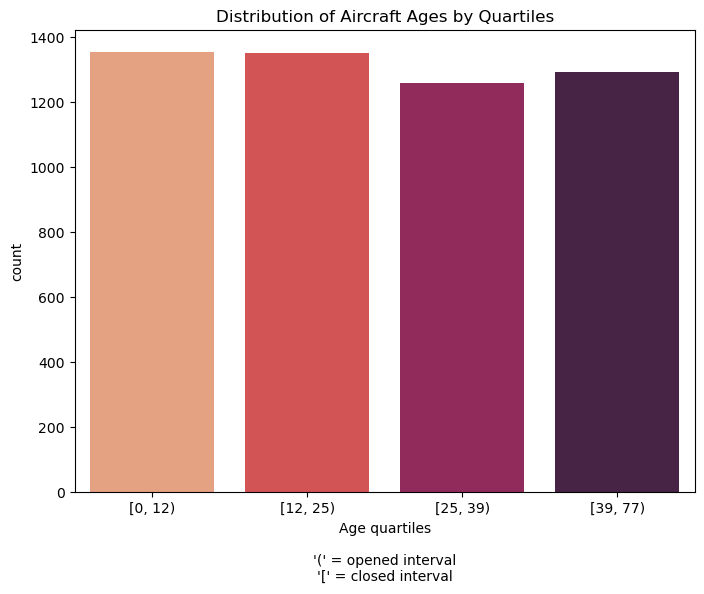

In [ ]:
quartis = [0, 12, 25, 39, 77]

# Cria uma nova coluna 'quartis_idade' baseada nos limites
dados['quartis_idade'] = pd.cut(dados['idade_aeronave'], bins=quartis, right=False)

plt.figure(figsize=(8,6))
sns.countplot(data=dados, x="quartis_idade", palette="rocket_r")
plt.xlabel("Age quartiles\n\n'(' = opened interval\n'[' = closed interval")
plt.title("Distribution of Aircraft Ages by Quartiles")
plt.show()


#### Analyzing the wind distribution for new and old aircraft

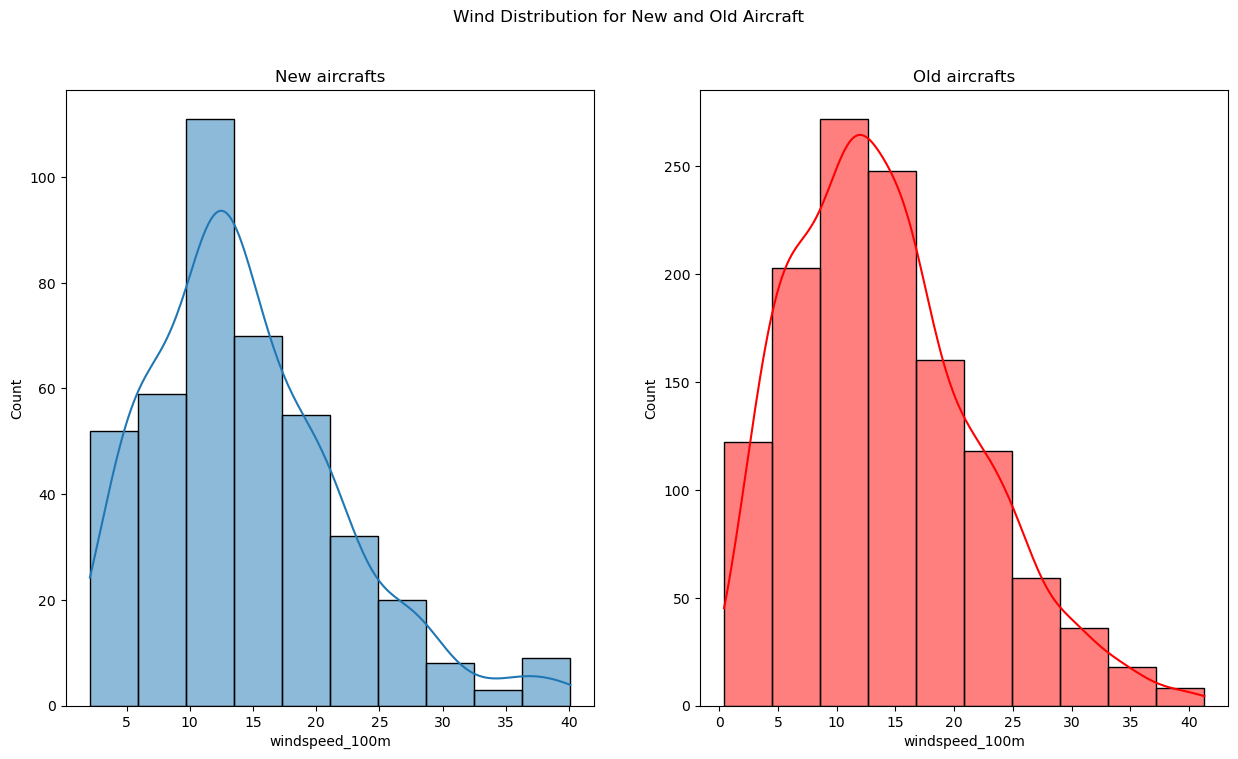

In [ ]:
new= df_weather[df_weather["idade_aeronave"] <= 11].drop_duplicates()
old = df_weather[df_weather["idade_aeronave"] > 11].drop_duplicates()

fig, axs = plt.subplots(1,2, figsize=(15, 8))
sns.histplot(data=new, x="windspeed_100m", kde=True, bins=10, ax=axs[0])
axs[0].set_title("New aircrafts")
sns.histplot(data=old, x="windspeed_100m", kde=True, bins=10, ax=axs[1], color='r')
axs[1].set_title("Old aircrafts")
fig.suptitle("Wind Distribution for New and Old Aircraft")
plt.show()

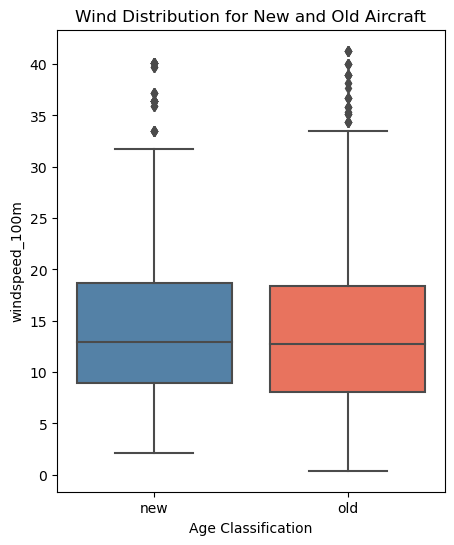

In [ ]:
df_weather["classificacao_idade"] = "new"
df_weather.loc[df_weather["idade_aeronave"] > 11, "classificacao_idade"] = "old"

plt.figure(figsize=(5, 6))
sns.boxplot(data=df_weather, y="windspeed_100m", x="classificacao_idade", showfliers=True, palette={"new": "steelblue", "old": "tomato"})
plt.xlabel("Age Classification")
plt.title("Wind Distribution for New and Old Aircraft")
plt.show()


#### Damage Level Analysis

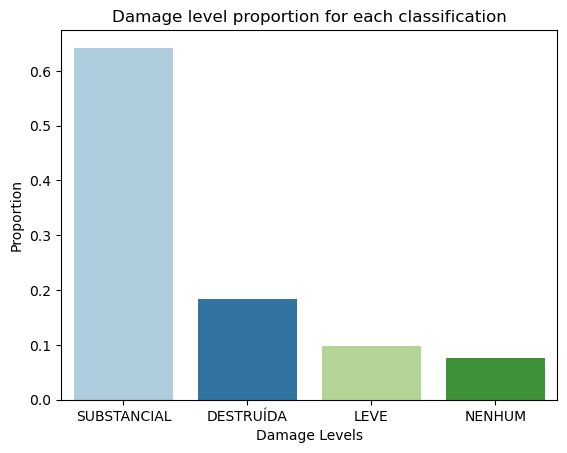

In [ ]:
sns.barplot(x=dados["aeronave_nivel_dano"].value_counts(normalize=True).index,
             y=dados["aeronave_nivel_dano"].value_counts(normalize=True),
             palette="Paired"
            )
plt.title("Damage level proportion for each classification")
plt.ylabel("Proportion")
plt.xlabel("Damage Levels")
plt.show()

In [ ]:
proportions_damage_age = pd.crosstab(dados["quartis_idade"], dados["aeronave_nivel_dano"], normalize="index")
proportions_damage_age

aeronave_nivel_dano,DESTRUÍDA,LEVE,NENHUM,SUBSTANCIAL
quartis_idade,,,,
"[0, 12)",0.158050,0.119645,0.147710,0.574594
"[12, 25)",0.227811,0.119822,0.066568,0.585799
"[25, 39)",0.163752,0.093800,0.042925,0.699523
"[39, 77)",0.187017,0.054096,0.042504,0.716383


In [ ]:
long_p_damage_age = pd.melt(proportions_damage_age.reset_index(), id_vars=['quartis_idade'], value_vars=proportions_damage_age.columns.tolist(), var_name='Nivel', value_name='Proportion').sort_values(by="Proportion", ascending=False)
long_p_damage_age

,quartis_idade,Nivel,Proportion
15,"[39, 77)",SUBSTANCIAL,0.716383
14,"[25, 39)",SUBSTANCIAL,0.699523
13,"[12, 25)",SUBSTANCIAL,0.585799
12,"[0, 12)",SUBSTANCIAL,0.574594
1,"[12, 25)",DESTRUÍDA,0.227811
3,"[39, 77)",DESTRUÍDA,0.187017
2,"[25, 39)",DESTRUÍDA,0.163752
0,"[0, 12)",DESTRUÍDA,0.158050
8,"[0, 12)",NENHUM,0.147710
5,"[12, 25)",LEVE,0.119822


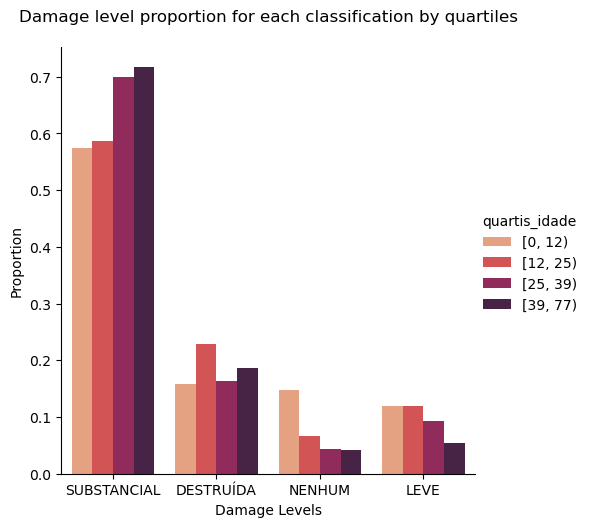

In [ ]:
sns.catplot(data=long_p_damage_age, x="Nivel", y="Proportion", hue="quartis_idade", kind="bar", palette="rocket_r")
plt.title("Damage level proportion for each classification by quartiles\n")
plt.ylabel("Proportion")
plt.xlabel("Damage Levels")
plt.show()

#### Analysis of the type of occurrence

In [ ]:
proportions_type_age = pd.crosstab(dados["quartis_idade"], dados["ocorrencia_classificacao"], normalize="index")
proportions_type_age

ocorrencia_classificacao,ACIDENTE,INCIDENTE,INCIDENTE GRAVE
quartis_idade,,,
"[0, 12)",0.741507,0.019941,0.238552
"[12, 25)",0.789941,0.005178,0.204882
"[25, 39)",0.844992,0.006359,0.148649
"[39, 77)",0.891808,0.000000,0.108192


In [ ]:
long_p_type_age = pd.melt(proportions_type_age.reset_index(), id_vars=['quartis_idade'], value_vars=proportions_type_age.columns.tolist(), var_name='type_of_occurrence', value_name='Proportion').sort_values(by="Proportion", ascending=False)
long_p_type_age

,quartis_idade,type_of_occurrence,Proportion
3,"[39, 77)",ACIDENTE,0.891808
2,"[25, 39)",ACIDENTE,0.844992
1,"[12, 25)",ACIDENTE,0.789941
0,"[0, 12)",ACIDENTE,0.741507
8,"[0, 12)",INCIDENTE GRAVE,0.238552
9,"[12, 25)",INCIDENTE GRAVE,0.204882
10,"[25, 39)",INCIDENTE GRAVE,0.148649
11,"[39, 77)",INCIDENTE GRAVE,0.108192
4,"[0, 12)",INCIDENTE,0.019941
6,"[25, 39)",INCIDENTE,0.006359


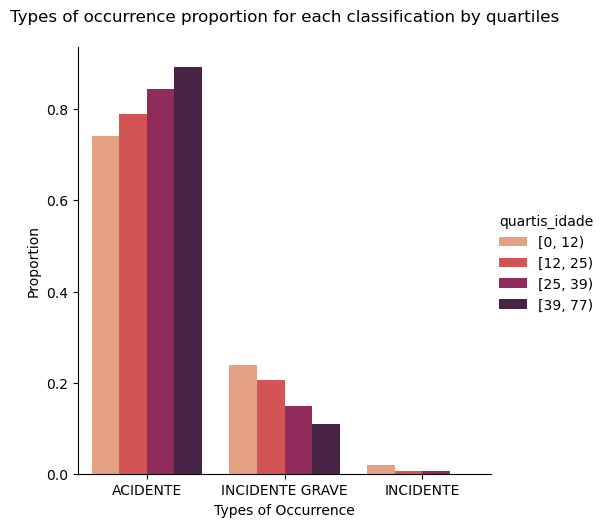

In [ ]:
sns.catplot(data=long_p_type_age, x="type_of_occurrence", y="Proportion", hue="quartis_idade", kind="bar", palette="rocket_r")
plt.title("Types of occurrence proportion for each classification by quartiles\n")
plt.ylabel("Proportion")
plt.xlabel("Types of Occurrence")
plt.show()

#### Analysis of the type of occurrence for old and new aircraft

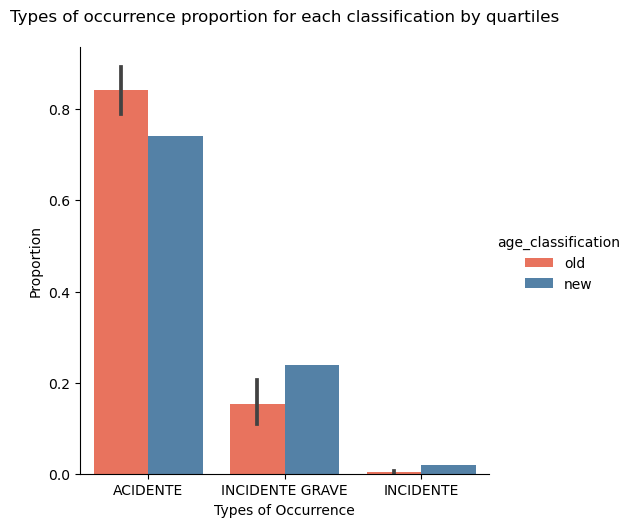

In [ ]:
long_p_type_age["age_classification"] = "new"
long_p_type_age.loc[~(long_p_type_age["quartis_idade"] == pd.Interval(quartis[0], quartis[1], closed='left')), "age_classification"] = "old"
sns.catplot(data=long_p_type_age, x="type_of_occurrence", y="Proportion", hue="age_classification", kind="bar", palette={"new": "steelblue", "old": "tomato"})
plt.title("Types of occurrence proportion for each classification by quartiles\n")
plt.ylabel("Proportion")
plt.xlabel("Types of Occurrence")
plt.show()

#### Incident analysis by factor

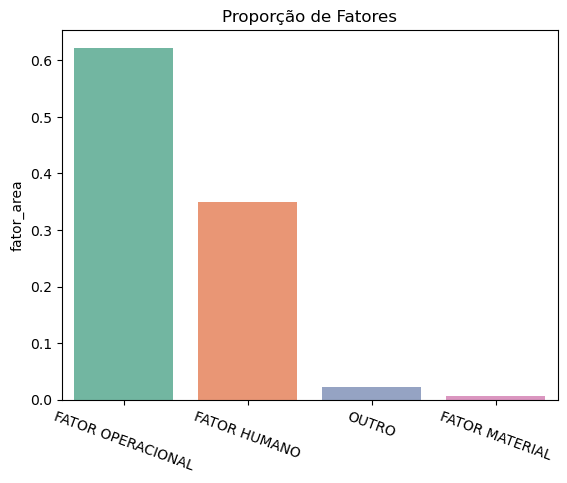

In [ ]:
sns.barplot(x=dados["fator_area"].value_counts(normalize=True).index,
             y=dados["fator_area"].value_counts(normalize=True),
             palette="Set2"
            )
plt.title("Proporção de Fatores")
plt.xticks(rotation=-20)
plt.show()

#### Correlation matrix between Aircraft age and Area Factor

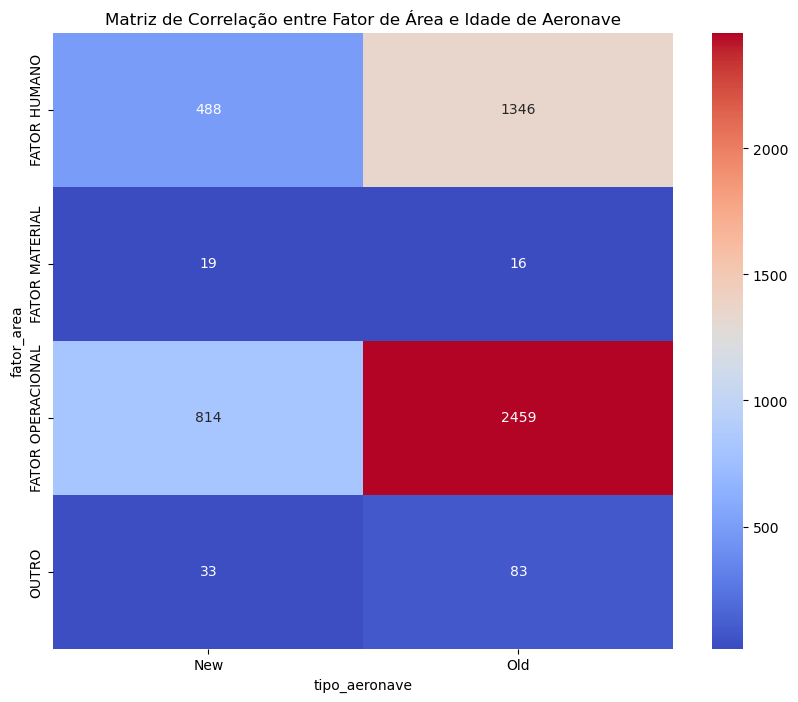

In [ ]:
# Cria uma coluna para identificar se a aeronave é nova ou velha
dados['tipo_aeronave'] = ['New' if q == pd.Interval(quartis[0], quartis[1], closed='left') else 'Old' for q in dados['quartis_idade']]

# Calcula a matriz de correlação
correlation_matrix = dados.groupby(['fator_area', 'tipo_aeronave']).size().unstack().fillna(0)

# Plota o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='g')
plt.title('Matriz de Correlação entre Fator de Área e Idade de Aeronave')
plt.show()


### 4. Drawing Inferences

Analyzing the charts we can propose the hypothesis:


1.  There's a difference between the proportion of accidents in aircraft older than 11 years than on aircraft newer than 11 years. (José)
2.  Is there differences among the averages of airplanes in each damage level? If so, between which ones? (Igor)
3.  The proportion of airplanes with greater than or equal 11 years which had substantial damage in the occurrences is significantly greater than proportion of airplanes with less than 11 years.(Igor)
4.  Is there a significant relationship between the occurrence factor and the age of the aircraft? (Ingrid)
5.  Older aircraft are more susceptible to experiencing incidents due to the passage of time. (José)





#### 4.1

**Checking Hypothesis**

> There's a difference between the proportion of accidents in aircrafts older than 11 years then on aircrafts newer than 11 years.



**Hypothesis Formulation**
- $H_0$ = There's no difference between the proportion of accidents in aircraft older than 11 years than on aircraft newer than 11 years
    > $p_{>11} - p_{<=11} = 0$


- $H_A$ = There's a difference between the proportion of accidents in aircraft older than 11 years than in aircraft newer than 11 years
    > $p_{>10} - p_{<=10} ≠ 0$



**Checking conditions for the sampling distribution of $p̂_1$ − $p̂_2$ to be normal:**



1.   **Independence**

* Because the data come from a simple random sample,
the observations are independent, both within and between samples.

2.   **Success-failure condition**

* Since the null hypothesis is that the proportions are equal, we use the pooled proportion ($p̂_{pooled}$)
to verify the success-failure condition and estimate the standard error.
* $p̂_{pooled} = \frac{{p̂_1 n_1 + p̂_2 n_2}}{{n_1 + n_2 }}$
* $n_1 * p̂_{pooled} \geq 10$ and $n_1 * (1-p̂_{pooled}) \geq 10$
* $n_2 * p̂_{pooled} \geq 10$ and $n_2 * (1-p̂_{pooled}) \geq 10$

In [ ]:
# Given data
SAMPLE_SIZE_ACCIDENTS = 300

sample_accidents = dados[dados["ocorrencia_classificacao"] == "ACIDENTE"].sample(n=SAMPLE_SIZE_ACCIDENTS, replace=False, axis=0)

accident_proportions = sample_accidents.tipo_aeronave.value_counts(normalize=True)
accident_counts = sample_accidents.tipo_aeronave.value_counts()

confidence_level = 0.95

# Using the pooled proportion when H0 is p1-p2 = 0
p_pooled= (accident_proportions.New * accident_counts.New + accident_proportions.Old * accident_counts.Old) / SAMPLE_SIZE_ACCIDENTS
print(f"For n1 = {accident_counts.New}\n"
        f"    n2 = {accident_counts.Old}\n\n"
        f"p̂_1 = {accident_proportions.New}\n"
        f"p̂_2 = {accident_proportions.Old}\n"
        f"p̂_pooled = {p_pooled}"
    )


For n1 = 67
    n2 = 233

p̂_1 = 0.22333333333333333
p̂_2 = 0.7766666666666666
p̂_pooled = 0.6530888888888888


In [ ]:
ck1 = p_pooled * accident_counts.New
ck2 = (1 - p_pooled) * accident_counts.New

if ck1 >= 10 and ck2 >= 10:
    print("Conditions 𝑛1 * 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛1 * (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 met!")
else:
    print("Conditions 𝑛1 * 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛1 * (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 DOES NOT met!")

ck3 = p_pooled * accident_counts.Old
ck4 = (1 - p_pooled) * accident_counts.Old

if ck3 >= 10 and ck4 >= 10:
    print("Conditions 𝑛2 * 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛2 * (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 met!")
else:
    print("Conditions 𝑛2 * 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛2 * (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 DOES NOT met!")

Conditions 𝑛1 * 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛1 * (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 met!
Conditions 𝑛2 * 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛2 * (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 met!


**As both conditions are satisfied, we can safely model the difference in proportions using a normal distribution!**

**Standard error for the difference of proportions**


$SE = \sqrt{\frac{{(p̂_{pooled} * (1-p̂_{pooled})}}{{n_1}} + \frac{{(p̂_{pooled} * (1-p̂_{pooled})}}{{n_2}}}$

In [ ]:
# Calculate the standard error
standard_error_accident = np.sqrt(
    ((p_pooled * (1 - p_pooled)) / accident_counts.New) # Newer SE
    +
    ((p_pooled * (1 - p_pooled)) / accident_counts.Old) # Older SE
)

print("SE =", standard_error_accident)

SE = 0.06598428544680866


**Point Estimate**

$point \ estimate = 𝑝̂_1 - 𝑝̂_2$

In [ ]:
#Point estimate
point_estimate_accident = accident_proportions.Old - accident_proportions.New
print("point_estimate =", point_estimate_accident)

point_estimate = 0.5533333333333332


**Null Value**

In [ ]:
null_value_accident = 0     # it comes from the null hypothesis, since we are considering the difference between proportions 0
print("Null value =", null_value_accident)
print("It comes from the null hypothesis, since we are considering the difference between proportions 0")

Null value = 0
It comes from the null hypothesis, since we are considering the difference between proportions 0


**Test Statistic**

$Z^{*} = \frac{{\text{point estimate} - \text{null value}}}{{SE}}$

In [ ]:
z_score_accident = (point_estimate_accident - null_value_accident) / standard_error_accident
print("Test statistic (Z*) =", z_score_accident)

Test statistic (Z*) = 8.385835045215227


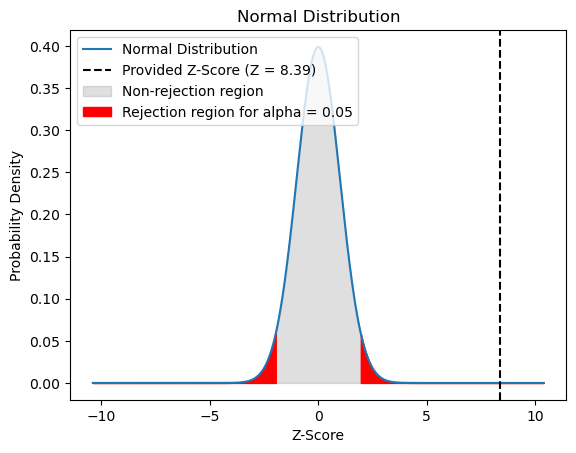

In [ ]:
plot_normal_distribution(z_score_accident, alpha=0.05)

In [ ]:
p_value = stats.norm.sf(abs(z_score_accident)) * 2
alpha = 0.05

if p_value < alpha:
    print(f"For a p-value = {p_value} and alpha = {alpha} we REJECT the null hypothesis!")
else:
    print(f"For a p-value = {p_value} and alpha = {alpha} we DO NOT REJECT the null hypothesis!")

For a p-value = 5.0366922389474583e-17 and alpha = 0.05 we REJECT the null hypothesis!


**Confidence Interval**

In [ ]:
z_critical = stats.norm.ppf(1 - alpha / 2)

# Calculate the margin of error for the confidence interval
margin_of_error_accident = z_critical * standard_error_accident

confidence_interval_lower_accident = point_estimate_accident - margin_of_error_accident
confidence_interval_upper_accident = point_estimate_accident + margin_of_error_accident

confidence_interval_accident = (confidence_interval_lower_accident , confidence_interval_upper_accident)
print(f"Since the confidence interval {confidence_interval_accident} do not have 0, there is additional evidence to reject the null hypothesis")


Since the confidence interval (0.42400651031197784, 0.6826601563546886) do not have 0, there is additional evidence to reject the null hypothesis


In [ ]:
def to_percentual_points(n):
  return round(n*100, 2)
print(f"We can confirm with a {confidence_level * 100}% confindence level that older aircrafts tend to have\
 {to_percentual_points(confidence_interval_lower_accident)}PP to {to_percentual_points(confidence_interval_upper_accident)}PP more accidents than newer ones")

We can confirm with a 95.0% confindence level that older aircrafts tend to have 42.4PP to 68.27PP more accidents than newer ones


#### 4.2 ANOVA TEST

**Age Distribution Per Damage Level**

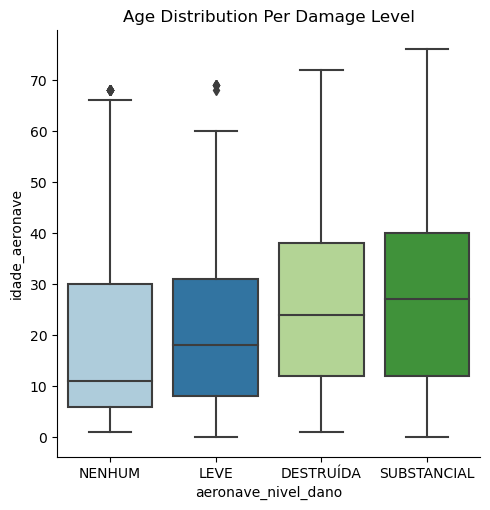

In [ ]:
order_by_median = dados.groupby("aeronave_nivel_dano")["idade_aeronave"].median().sort_values().index
sns.catplot(data=dados, x="aeronave_nivel_dano", y="idade_aeronave", kind="box", palette="Paired", order=order_by_median)
plt.title("Age Distribution Per Damage Level")
plt.show()

We can even think if there is difference between the averages of ages for each category of damage level. To check this, we will use ANOVA.

**Hypothesis Formulation**

$H_0:$ There IS NO difference between the averages of airplanes ages for each category of damage level.


> $μ_{NENHUM}=μ_{SUBSTANCIAL}=μ_{LEVE}=μ_{DESTRUIDA}$

$H_A$: The average of airplane ages (µ) varies across some (or all) groups.

In [ ]:
SAMPLE_SIZE_ANOVA = 150

sample_category_none = dados[dados["aeronave_nivel_dano"] == "NENHUM"].sample(n=SAMPLE_SIZE_ANOVA, replace=False, axis=0, ignore_index=True)
sample_category_light = dados[dados["aeronave_nivel_dano"] == "LEVE"].sample(n=SAMPLE_SIZE_ANOVA, replace=False, axis=0, ignore_index=True)
sample_category_substancial = dados[dados["aeronave_nivel_dano"] == "SUBSTANCIAL"].sample(n=SAMPLE_SIZE_ANOVA, replace=False, axis=0, ignore_index=True)
sample_category_destructed = dados[dados["aeronave_nivel_dano"] == "DESTRUÍDA"].sample(n=SAMPLE_SIZE_ANOVA, replace=False, axis=0, ignore_index=True)

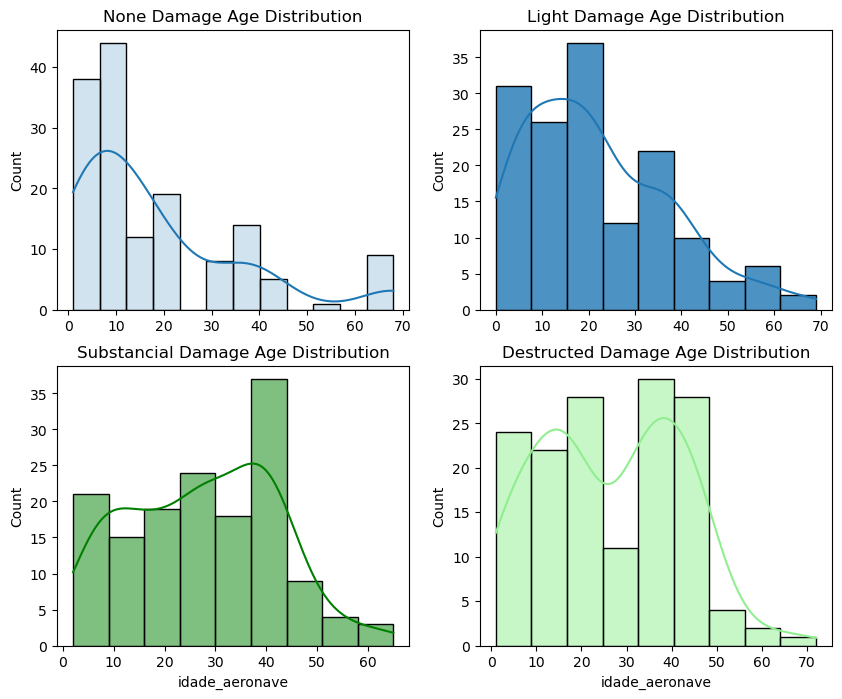

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(10,8))

sns.histplot(data=sample_category_none, x="idade_aeronave", kde=True, ax=axs[0,0], alpha=0.2)
axs[0,0].set_title("None Damage Age Distribution")
axs[0,0].set_xlabel("")

sns.histplot(data=sample_category_light, x="idade_aeronave", kde=True, ax=axs[0,1], alpha=0.8)
axs[0,1].set_title("Light Damage Age Distribution")
axs[0,1].set_xlabel("")

sns.histplot(data=sample_category_substancial, x="idade_aeronave", kde=True, ax=axs[1,0], color="green")
axs[1,0].set_title("Substancial Damage Age Distribution")

sns.histplot(data=sample_category_destructed, x="idade_aeronave", kde=True, ax=axs[1,1], color="lightgreen")
axs[1,1].set_title("Destructed Damage Age Distribution")

plt.show()

Variance for each category

In [ ]:
print(f"Variances for each damage level for n1 = n2 = n3 = n4 = {SAMPLE_SIZE_ANOVA}\n")
print("None damage variance:", np.std(sample_category_none["idade_aeronave"]) ** 2)
print("Light damage variance:", np.std(sample_category_light["idade_aeronave"]) ** 2)
print("Substancial damage variance:", np.std(sample_category_substancial["idade_aeronave"]) ** 2)
print("Destructed damage variance:", np.std(sample_category_destructed["idade_aeronave"]) ** 2)

Variances for each damage level for n1 = n2 = n3 = n4 = 150

None damage variance: 310.5555555555558
Light damage variance: 240.6500000000001
Substancial damage variance: 212.05000000000004
Destructed damage variance: 251.04782222222235


**Checking conditions to apply ANOVA**


1.  **Independence between and within each category**
* Since we are taking simple random samples, this condition is checked.
2.   **Approximately normal distribution of each group**
* We can check looking at the charts that the normality is not so approximated, even more in the None damage one, which is a right skewed chart. However, since we are taking large samples (n=150) we will relax this point.
3. **Constant variance comparing the groups**
* We can consider the variances for each category approximately equal, for this taken sample.



Relaxing the point 2 above, we will apply ANOVA to check if there are differences between the average ages across the 4 groups.

**Applying ANOVA (F-test) for 0.05 significance level**

In [ ]:
from scipy.stats import f_oneway
ages_none = sample_category_none["idade_aeronave"]
ages_light = sample_category_light["idade_aeronave"]
ages_substancial = sample_category_substancial["idade_aeronave"]
ages_destructed = sample_category_destructed["idade_aeronave"]

alpha_anova = 0.05
f_score, p_value_anova = f_oneway(ages_none, ages_light, ages_substancial, ages_destructed)
print(f"F-score gotten: {f_score}\n")

if p_value_anova < alpha_anova:
    print(f"For a p-value = {p_value_anova} and alpha = {alpha_anova} we REJECT the null hypothesis!")
else:
    print(f"For a p-value = {p_value_anova} and alpha = {alpha_anova} we DO NOT REJECT the null hypothesis!")

F-score gotten: 10.8146977079456

For a p-value = 6.298589689096576e-07 and alpha = 0.05 we REJECT the null hypothesis!


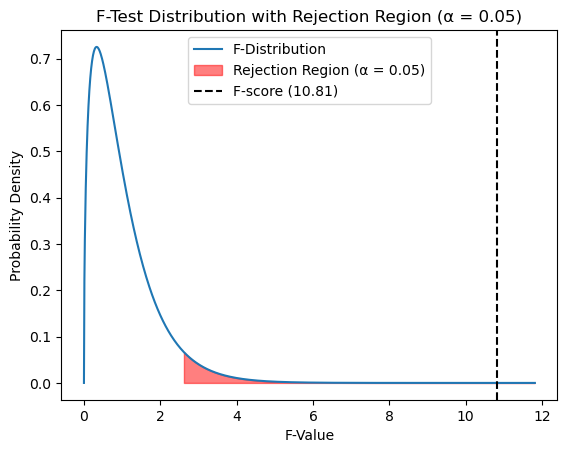

In [ ]:
k = len(dados["aeronave_nivel_dano"].unique())
dfg = k - 1
dfe = k * SAMPLE_SIZE_ANOVA - k

plot_f_test_distribution(f_score, dfg, dfe, alpha=0.05)

**First Conclusion**

As we rejected the null hypothesis, we can conclude that there are differences between the averages of ages among the damage levels.

However, **we still do not know which levels are different from others**. To do that, we will apply the t-test with some modifications for each pair of categories and check which pairs reject the null hypothesis.

**Applying BONFERRONI correction for 𝛂**

$\alpha^*_{BONFERRONI} = \frac{\alpha}{number \ of \ pairs \ to \ compare}$ 

In [ ]:
k = len(dados["aeronave_nivel_dano"].unique())
number_of_pairs = k * (k - 1) / 2
alpha_bonferroni = alpha_anova / number_of_pairs

print(f"Number of pairs to compare = {int(number_of_pairs)}")
print(f"α*(Bonferroni) = {alpha_bonferroni}")

Number of pairs to compare = 6
α*(Bonferroni) = 0.008333333333333333


In [ ]:
dfg = k - 1
dfe = k * SAMPLE_SIZE_ANOVA - k

print(f"dfG = {dfg}")
print(f"dfE = {dfe}")

dfG = 3
dfE = 596


**Comparing each pair**

**Standard error for the difference of proportions**

$SE=\sqrt{\frac{s_{pooled^2}}{n_1}+\frac{s_{pooled^2}}{n_2}}$

**Test statistic**

$T^*= \frac{{\text{point estimate} - \text{null value}}}{{SE}}$

**Significance level we will use**

$\alpha* (Bonferroni) = 0.0083$

In [ ]:
all_anova_samples = pd.concat([sample_category_none, sample_category_light,
                               sample_category_substancial, sample_category_destructed], axis=0)
s_pooled = np.std(all_anova_samples["idade_aeronave"])
print("s_pooled =", s_pooled)

s_pooled = 16.834370842614426


In [ ]:
damage_levels = ['none', 'light', 'substancial', 'destructed']
anova_samples = [sample_category_none["idade_aeronave"],
                 sample_category_light["idade_aeronave"],
                 sample_category_substancial["idade_aeronave"],
                 sample_category_destructed["idade_aeronave"]
                 ]

null_value_anova = 0

# comparing all pairs
for i in range(k):
    for j in range(i + 1, k):
        level1, level_sample1 = damage_levels[i], anova_samples[i]
        level2, level_sample2 = damage_levels[j], anova_samples[j]
        print(f"Pair ({level1}, {level2}):")

        avg1 = np.mean(level_sample1)
        print(f"    x̄1 ({level1} damage level):", avg1)

        avg2 = np.mean(level_sample2)
        print(f"    x̄2 ({level2} damage level):", avg2)

        pe = avg1 - avg2
        print("    Point Estimate (x̄1 - x̄2):", pe)

        SE_anova = sqrt(s_pooled ** 2 / len(level_sample1) +
                        s_pooled ** 2 / len(level_sample2)
                        )
        print("    SE:", SE_anova)

        t_score_anova = (pe - null_value_anova) / SE_anova
        print("    abs t_score:", abs(t_score_anova))

        pvalue_pair = stats.t.sf(abs(t_score_anova), dfe)
        print()

        if pvalue_pair < alpha_bonferroni:
            print(f"    For a p-value of pairs {level1}, {level2} = {pvalue_pair} and alpha bonferroni = {alpha_bonferroni} we REJECT the null hypothesis!")
        else:
            print(f"    For a p-value of pairs {level1}, {level2} = {pvalue_pair} and alpha bonferroni = {alpha_bonferroni} we DO NOT REJECT the null hypothesis!")
        print()


Pair (none, light):
    x̄1 (none damage level): 18.493333333333332
    x̄2 (light damage level): 21.346666666666668
    Point Estimate (x̄1 - x̄2): -2.8533333333333353
    SE: 1.9438657075242853
    abs t_score: 1.4678654612243514

    For a p-value of pairs none, light = 0.07133414642722537 and alpha bonferroni = 0.008333333333333333 we DO NOT REJECT the null hypothesis!

Pair (none, substancial):
    x̄1 (none damage level): 18.493333333333332
    x̄2 (substancial damage level): 28.8
    Point Estimate (x̄1 - x̄2): -10.306666666666668
    SE: 1.9438657075242853
    abs t_score: 5.302149539843098

    For a p-value of pairs none, substancial = 8.073149563168005e-08 and alpha bonferroni = 0.008333333333333333 we REJECT the null hypothesis!

Pair (none, destructed):
    x̄1 (none damage level): 18.493333333333332
    x̄2 (destructed damage level): 27.66
    Point Estimate (x̄1 - x̄2): -9.166666666666668
    SE: 1.9438657075242853
    abs t_score: 4.715689273793182

    For a p-value of

**4.3**

**Checking Hypothesis:**


> The proportion of airplanes with greater than or equal 11 years which had substancial damage in the occurences is significantly greater than proportion of airplanes with less than 11 years



In [ ]:
dados

,aeronave_ano_fabricacao,aeronave_nivel_dano,aeronave_fatalidades_total,fator_area,ocorrencia_classificacao,ocorrencia_dia,idade_aeronave,ocorrencia_longitude,ocorrencia_latitude,ocorrencia_hora,timestamp,quartis_idade,tipo_aeronave
45331,2001.0,NENHUM,0.0,FATOR OPERACIONAL,ACIDENTE,06/01/2012,11.0,-46.4730555556,-23.4355555556,13:44:00,2012-06-01 13:00:00,Q2,Velha
45331,2001.0,NENHUM,0.0,FATOR HUMANO,ACIDENTE,06/01/2012,11.0,-46.4730555556,-23.4355555556,13:44:00,2012-06-01 13:00:00,Q2,Velha
45331,2001.0,NENHUM,0.0,FATOR HUMANO,ACIDENTE,06/01/2012,11.0,-46.4730555556,-23.4355555556,13:44:00,2012-06-01 13:00:00,Q2,Velha
45331,2001.0,NENHUM,0.0,FATOR HUMANO,ACIDENTE,06/01/2012,11.0,-46.4730555556,-23.4355555556,13:44:00,2012-06-01 13:00:00,Q2,Velha
45331,2001.0,NENHUM,0.0,FATOR HUMANO,ACIDENTE,06/01/2012,11.0,-46.4730555556,-23.4355555556,13:44:00,2012-06-01 13:00:00,Q2,Velha
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81169,1994.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,07/12/2022,28.0,-47.96638888888,-16.26194444444,14:50:00,2022-07-12 14:00:00,Q3,Velha
81169,1994.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,07/12/2022,28.0,-47.96638888888,-16.26194444444,14:50:00,2022-07-12 14:00:00,Q3,Velha
81169,1994.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,07/12/2022,28.0,-47.96638888888,-16.26194444444,14:50:00,2022-07-12 14:00:00,Q3,Velha
81169,1994.0,SUBSTANCIAL,0.0,FATOR HUMANO,ACIDENTE,07/12/2022,28.0,-47.96638888888,-16.26194444444,14:50:00,2022-07-12 14:00:00,Q3,Velha


In [ ]:
# taking broad samples
SAMPLE_SIZE_2 = 100
less_11_2 = dados[dados["tipo_aeronave"] == 'Nova'].copy()

more11_2 = dados[dados["tipo_aeronave"] == 'Velha'].copy()
more11_2

,aeronave_ano_fabricacao,aeronave_nivel_dano,aeronave_fatalidades_total,fator_area,ocorrencia_classificacao,ocorrencia_dia,idade_aeronave,ocorrencia_longitude,ocorrencia_latitude,ocorrencia_hora,timestamp,quartis_idade,tipo_aeronave
45331,2001.0,NENHUM,0.0,FATOR OPERACIONAL,ACIDENTE,06/01/2012,11.0,-46.4730555556,-23.4355555556,13:44:00,2012-06-01 13:00:00,Q2,Velha
45331,2001.0,NENHUM,0.0,FATOR HUMANO,ACIDENTE,06/01/2012,11.0,-46.4730555556,-23.4355555556,13:44:00,2012-06-01 13:00:00,Q2,Velha
45331,2001.0,NENHUM,0.0,FATOR HUMANO,ACIDENTE,06/01/2012,11.0,-46.4730555556,-23.4355555556,13:44:00,2012-06-01 13:00:00,Q2,Velha
45331,2001.0,NENHUM,0.0,FATOR HUMANO,ACIDENTE,06/01/2012,11.0,-46.4730555556,-23.4355555556,13:44:00,2012-06-01 13:00:00,Q2,Velha
45331,2001.0,NENHUM,0.0,FATOR HUMANO,ACIDENTE,06/01/2012,11.0,-46.4730555556,-23.4355555556,13:44:00,2012-06-01 13:00:00,Q2,Velha
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81169,1994.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,07/12/2022,28.0,-47.96638888888,-16.26194444444,14:50:00,2022-07-12 14:00:00,Q3,Velha
81169,1994.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,07/12/2022,28.0,-47.96638888888,-16.26194444444,14:50:00,2022-07-12 14:00:00,Q3,Velha
81169,1994.0,SUBSTANCIAL,0.0,FATOR OPERACIONAL,ACIDENTE,07/12/2022,28.0,-47.96638888888,-16.26194444444,14:50:00,2022-07-12 14:00:00,Q3,Velha
81169,1994.0,SUBSTANCIAL,0.0,FATOR HUMANO,ACIDENTE,07/12/2022,28.0,-47.96638888888,-16.26194444444,14:50:00,2022-07-12 14:00:00,Q3,Velha


*Notice:*
*   $p̂ \leq 11$ represents the proportion of airplanes with lessor equal 11 years which had substancial damage in the occurences.
*   $p̂ \geq 10$ represents the proportion of airplanes with more than 11 years which had substancial damage in the occurences.

**Hypothesis Formulation**

$H_0$: There **IS NO** difference between proportions of airplanes with less than 20 years and more than or equal 20 years which had substancial damage.


> $p̂ \geq 11 − p̂ \leq 11 = 0$


$H_A$: There **IS** difference between proportions of airplanes with less than 10 years and more than or equal 10 years which had no damage.


> $p̂ \geq 11 − p̂ \leq 11 ≠ 0$

**Checking conditions for the sampling distribution of p̂1 − p̂2 to be normal:**

1.   **Independence**

* Because the data come from a simple random sample,
the observations are independent, both within and between samples.

2.   **Success-failure condition**

* Since the null hypothesis is that the proportions are equal, we use the pooled proportion ($p̂_{pooled}$)
to verify the success-failure condition and estimate the standard error.
* $p_{pooled} = \sqrt{\frac{{(p̂_1  n_1) + (p̂_2  n_2)}}{{n_1 + n_2 }}}$
* $n_1 * p̂_{pooled} \geq 10$ and $n_1 * (1-p̂_{pooled}) \geq 10$
* $n_2 * p̂_{pooled} \geq 10$ and $n_2 * (1-p̂_{pooled}) \geq 10$

In [ ]:
p_hat_less11_2 = less_11_2["aeronave_nivel_dano"].value_counts(normalize=True).SUBSTANCIAL
print("p-hat less than or equal 11 =", p_hat_less11_2)

p-hat less than or equal 11 = 0.5663265306122449


In [ ]:
p_hat_more11_2 = more11_2["aeronave_nivel_dano"].value_counts(normalize=True).SUBSTANCIAL
print("p-hat more than or equal 11 =", p_hat_more11_2)

p-hat more than or equal 11 = 0.6641352278294953


In [ ]:
p_pooled_2 = (p_hat_less11_2 * SAMPLE_SIZE_2 + p_hat_more11_2 * SAMPLE_SIZE_2) / (SAMPLE_SIZE_2 + SAMPLE_SIZE_2)
print("p-hat pooled =", p_pooled_2)

p-hat pooled = 0.61523087922087


In [ ]:
ck1_2 = p_pooled_2 * SAMPLE_SIZE_2
ck2_2 = (1 - p_pooled_2) * SAMPLE_SIZE_2

if ck1_2 >= 10 and ck2_2 >= 10:
    print("Conditions 𝑛1 𝑥 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛1 𝑥 (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 met!")
else:
    print("Conditions 𝑛1 𝑥 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛1 𝑥 (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 DOES NOT met!")

ck3_2 = p_pooled_2 * SAMPLE_SIZE_2
ck4_2 = (1 - p_pooled_2) * SAMPLE_SIZE_2

if ck3_2 >= 10 and ck4_2 >= 10:
    print("Conditions 𝑛2 𝑥 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛2 𝑥 (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 met!")
else:
    print("Conditions 𝑛2 𝑥 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛2 𝑥 (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 DOES NOT met!")

Conditions 𝑛1 𝑥 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛1 𝑥 (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 met!
Conditions 𝑛2 𝑥 𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑 ≥ 10 𝑎𝑛𝑑 𝑛2 𝑥 (1−𝑝̂ 𝑝𝑜𝑜𝑙𝑒𝑑) ≥ 10 met!


**As both conditions are satisfied, we can safely model the difference in proportions using a normal distribution!**

In [ ]:
SE_2 = sqrt(p_pooled_2*(1 - p_pooled_2) / len(less_11_2) + p_pooled_2*(1 - p_pooled_2) / len(more11_2))
print("SE =", SE_2)

SE = 0.016102351321662628


In [ ]:
point_estimate_2 = p_hat_more11_2 - p_hat_less11_2
print("Point estimate =", point_estimate_2)

Point estimate = 0.09780869721725038


In [ ]:
null_value_2 = 0     # it comes from the null hypothesis, since we are considering the difference between proportions 0
print("Null value =", null_value_2)
print("It comes from the null hypothesis, since we are considering the difference between proportions 0")

Null value = 0
It comes from the null hypothesis, since we are considering the difference between proportions 0


In [ ]:
z_score_2 = (point_estimate_2 - null_value_2) / SE_2
print("Test statistic (Z*) =", z_score_2)

Test statistic (Z*) = 6.074187257712327


In [ ]:
# p_value is calculate for one-tail and we are using two-tails
# because of this we must double the value encountered
p_value_2 = stats.norm.sf(abs(z_score_2)) * 2
alpha_2 = 0.05

if p_value_2 < alpha_2:
    print(f"For a p-value = {p_value_2} and alpha = {alpha_2} we REJECT the null hypothesis!")
else:
    print(f"For a p-value = {p_value_2} and alpha = {alpha_2} we DO NOT REJECT the null hypothesis!")

For a p-value = 1.246172430748684e-09 and alpha = 0.05 we REJECT the null hypothesis!


**4.4**

**Checking Hypothesis:**

> Is there a significant relationship between the occurrence factor and the age of the aircraft?

**Hypothesis Formulation**
*   $H_0$:  The age of the Aircraft is independent of the area factor (There is no significant association).

*   $H_A$:  The age of the Aircraft is dependent on the area factor (There is a significant association).


**Organization of Data in a Contingency Table**

In [ ]:
tabela_contingencia = pd.crosstab(dados['fator_area'],dados['tipo_aeronave'])
print(tabela_contingencia)


tipo_aeronave      Nova  Velha
fator_area                    
FATOR HUMANO        416   1418
FATOR MATERIAL       17     18
FATOR OPERACIONAL   715   2558
OUTRO                28     88


**Checking Conditions For The Chi-Square Test**

1.   **Independence**


*   Each case that contributes a count to the table is independent of all the other cases in the table and between each other.



2.  **Sample size / distribution**


*  Each particular scenario have at least 5 expected cases

In [ ]:
table = np.array([[416, 1418],
                  [17, 18],
                  [715, 2558],
                  [28, 88]])

def check_sample_size_distribution(table):
    # Checks whether each scenario has at least 5 expected cases
    for i in range(table.shape[0]):
        for j in range(table.shape[1]):
            expected = table[i, :].sum() * table[:, j].sum() / table.sum()
            if expected < 5:
                return False
    return True

# Check conditions
independence_condition = "Since each table are independent, True"
sample_size_condition = check_sample_size_distribution(table)

# View results
print(f'Independence Condition: {independence_condition}')
print(f'Sample Size/Distribution Condition: {sample_size_condition}')


Independence Condition: Since each table are independent, True
Sample Size/Distribution Condition: True


**As both conditions are satisfied, we can safely model the difference in proportions using a normal distribution!**

**Chi-Square Calculation**


$χ² = Σ [(O_{ij} - E_{ij})^² / E_{ij}]$
<br><br>

Where,

* $O_{ij}$ is the observed number of cases in cell $(i, j)$.

* $E_{ij}$ is the expected number of cases in cell $(i, j)$.






In [ ]:
qui_quadrado_obs = 0

# Loop para calcular o Qui-Quadrado Observado
for i in range(tabela_contingencia.shape[0]):
    for j in range(tabela_contingencia.shape[1]):
        O = tabela_contingencia.iloc[i, j]  # Valor observado
        soma_linha = tabela_contingencia.iloc[i, :].sum()
        soma_coluna = tabela_contingencia.iloc[:, j].sum()
        E = (soma_linha * soma_coluna) / tabela_contingencia.sum().sum()  # Valor esperado
        qui_quadrado_obs += ((O - E)**2) / E

print(f"Qui-Quadrado Observado: {qui_quadrado_obs}")

Qui-Quadrado Observado: 14.668940875667257


**Degrees of Freedom For a Two-Way Table**

$df=(R-1)*(C-1)$
Where,


$R$ is the number of rows in the table and $C$ is the number of columns.

In [ ]:
 df = (4 - 1) * (2 - 1)
 df

3

In [ ]:
# Significance Level (α)
alpha = 0.05

# Find the critical value
critical_value = chi2.ppf(1 - alpha, df)

print(f'Chi-Square critical value for α = {alpha} and df = {df}: {critical_value}')

Chi-Square critical value for α = 0.05 and df = 3: 7.814727903251179


In [ ]:
if qui_quadrado_obs > critical_value:
    print("Reject H0")
else:
    print("DO NOT Reject H0")

Reject H0


**P-Value Calculation**

In [ ]:
chi2_stat, p_value, _, _ = chi2_contingency(tabela_contingencia)
print(f'Valor-p: {p_value}')

Valor-p: 0.0021225732518976963


In [ ]:
# Interpretar o resultado
if p_value < 0.05:
    print(f'O valor-p é {p_value:}. There is additional statistical evidence to reject the null hypothesis.')
else:
    print(f'O valor-p é {p_value:}. There is not additional statistical evidence to reject the null hypothesis.')

O valor-p é 0.0021225732518976963. There is additional statistical evidence to reject the null hypothesis.


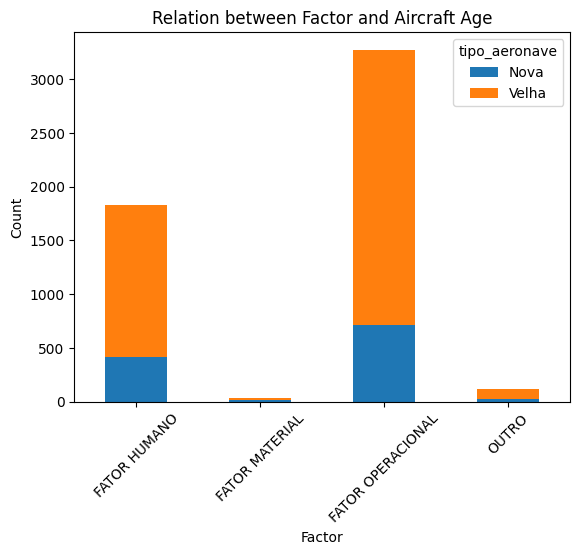

In [ ]:
tabela_contingencia.plot(kind='bar', stacked=True)
plt.xlabel('Factor')
plt.ylabel('Count')
plt.title('Relation between Factor and Aircraft Age')
plt.xticks(rotation=45)
plt.show()

**4.5**

**Checking Hypothesis:**

> Are older aircraft more susceptible to accidents due to wind?



**Hypothesis Formulation**


$H_0$: The average wind speed in accidents involving old and new aircraft is not different.



> $\mu_n -\mu_s = 0$, where $\mu_n$ represents non-smoking mothers and $\mu_s$ represents mothers who smoked.




$H_A$: The average wind speed in accidents involving old and new aircraft is different.


>  $\mu_n -\mu_s \neq 0$



**Checking conditions using the t-distribution for a difference in means**



1.   **Independence extended**

* The data are independent within and between the two groups.

2.   **Normality**

* We check the outliers rules of thumb for each group separately and there is no clear outliers in the data.

In [ ]:
# Given data
wind_newer = new["windspeed_100m"]
wind_older = old["windspeed_100m"]

confidence_level = 0.95

# Calculate the sample means
mean_wind_newer = np.mean(wind_newer)
mean_wind_older = np.mean(wind_older)

confidence_level = 0.95

**Standard Error Calculate**

$SE=\sqrt{\frac{{\sigma_1^2}}{{n_1}} + \frac{{\sigma_2^2}}{{n_2}}}$

In [ ]:
# Calculate the standard errors
std_error_newer = np.std(wind_newer, ddof=1) / np.sqrt(len(wind_newer))
std_error_older = np.std(wind_older, ddof=1) / np.sqrt(len(wind_older))

**Statistic Test**

$Z^{*} = \frac{{\text{point estimate} - \text{null value}}}{{SE}}$

In [ ]:
# Calculate the critical value (Z) for the desired confidence level
alpha = 1 - confidence_level
z_critical = stats.norm.ppf(1 - alpha / 2)
z_critical

1.959963984540054

**Margin of Error**

$M = Z^{*}*\sqrt{SE}$

In [ ]:
# Calculate the margin of error for the confidence interval
margin_of_error = z_critical * np.sqrt(std_error_newer**2 + std_error_older**2)
margin_of_error

0.5587497796810392

**Confidence Interval**

In [ ]:
# Calculate the confidence interval
mean_diff = mean_wind_older - mean_wind_newer
confidence_interval_lower = mean_diff - margin_of_error
confidence_interval_upper = mean_diff + margin_of_error


**Result**

In [ ]:
print(f"We can confirm with a {confidence_level * 100}% confidence level that older aircrafts has a mean of windspeed\
 between {round_n(confidence_interval_lower)} km/h and {round_n(confidence_interval_upper)} km/h more than newer ones.")

We can confirm with a 95.0% confidence level that older aircrafts has a mean of windspeed between -1.62 km/h and -0.5 km/h more than newer ones.


## **5. Conclusion**

**4.1**


Since we have rejected the null hypothesis, we can conclude that there is a difference in the proportion of accidents between aircraft older than 11 years and those newer than 11 years. Based on the confidence interval, we can also confirm with a 95% confidence level that older aircraft tend to have between 50.24 to 161.99 percentage points fewer accidents than newer ones.

**4.2**

Since we have rejected the null hypothesis, we can conclude that There IS difference between proportions of airplanes with less than or equal 11 years and more than 11 years which had no damage.

Furthermore, the point estimate indicate that the direction of that difference is that airplanes with less than or equal 11 years have proportions of occurences with no damage greater than airplanes with more than 11 years.

**4.3**

Since we have rejected the null hypothesis, we can conclude that There IS difference between proportions of airplanes with less than or equal 11 years and more than 11 years which had substancial damage.

Furthermore, the point estimate indicate that the direction of that difference is that airplanes with more than 11 years have proportions of occurences with susbtancial damage greater than airplanes with less than or equal 11 years.

**4.4**

Since we have rejected the null hypothesis, we can conclude that there is a significant relationship between the age of the aircraft and the factor of occurrences.

**4.5**

Since the confidence interval does not contain **0**, we can affirm with a 95.0% confidence level that older aircraft have a mean windspeed between -1.62 km/h and -0.5 km/h higher than newer ones.

*by Ingrid Diniz, Igor Diniz e José Santos*